# RGB Images
Here we're going to generate the single- and triple-channel images for the presentation.

Let's start with some imports.

In [5]:
%load_ext autoreload
%autoreload 2


from PIL import Image
from helper_functions import *
from window import *
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

from sklearn.metrics import jaccard_similarity_score

from sklearn.manifold import TSNE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Getting the basic settings right.

General flow will be:
 - Expanded RGB (2000x2000, 4000x4000, 5px pooling)
 - Zoomed RGB (1000x2000, 1600x900, 2px pooling) (location may change)
 - Zoomed ExpandedRGB
 - Zoomed TimeSeries
 - Zoomed Categories
 - Expanded Categories
 - Expanded USDA CDL

and stuff that's not maps.


In [6]:
location = (2000,2000)
shape = (4000,4000) # x, y
pool_size = (2,2)

landsat_dir = "data/landsat-8/024031/"
mvp_dates = ['2017-02-26', '2017-04-15', '2017-06-02', '2017-09-22', '2017-10-08', '2017-11-09', '2017-11-25']

# For understanding Cropland labels
labels_df = pd.read_csv("data/cdl/cdl_labels.csv", header=None)
labels_df.columns = ["value","label","red","green","blue","alpha","none"]
coded_labels = [ label.strip() for label in labels_df.label]

In [7]:
%%time
mvp_scene = Scene(landsat_dir, mvp_dates)
mvp = Window(mvp_scene, location, shape, pool_size)

CPU times: user 1min 34s, sys: 23.3 s, total: 1min 57s
Wall time: 2min 12s


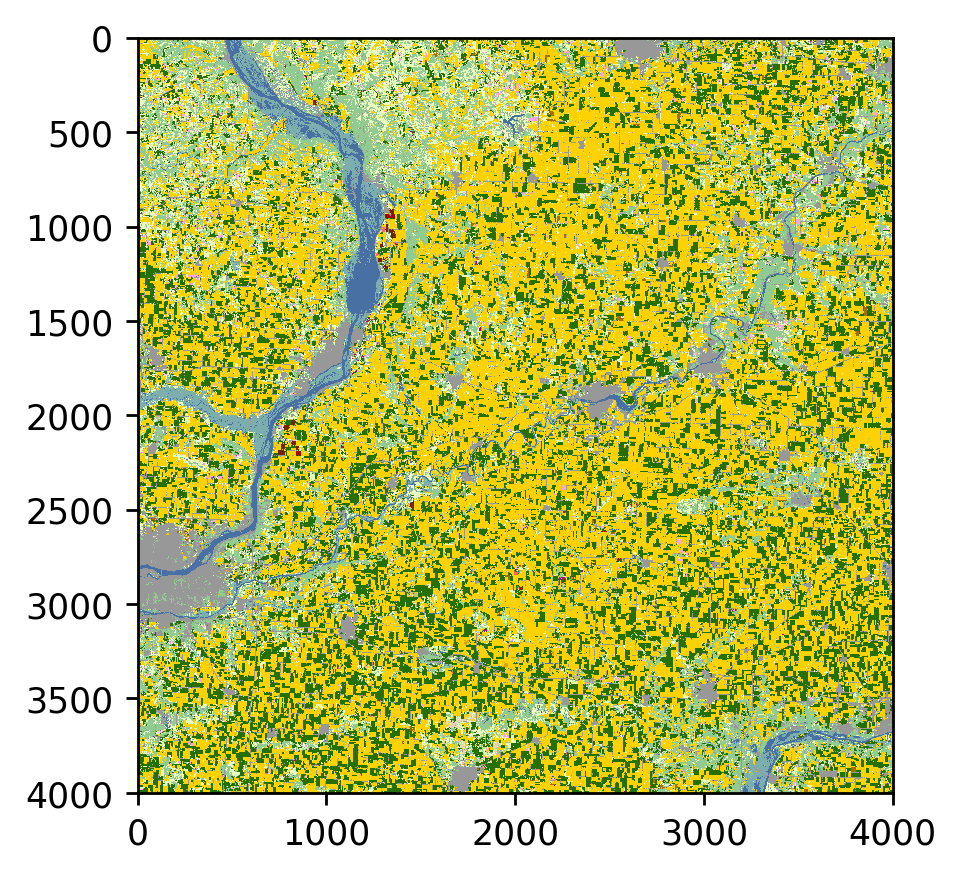

In [8]:
labeled_data = gdal.Open("data/cdl/CDL_2017_clip_20180619224955_1770132852.tif")
cmap = get_gdal_colormap(labeled_data)
crops = mvp.align(labeled_data)
plot_crop_layer(crops, cmap)

In [9]:
def display_counts( image ):
    cdl_band = labeled_data.GetRasterBand(1)
    color_table = cdl_band.GetColorTable()
    num_colors = color_table.GetCount()
    colors = np.array([color_table.GetColorEntry(i) for i in range(num_colors)])
    colors = colors / 255

    count = Counter(image.ravel())
    print("val | Label                           |  num | ( red,  grn, blue, a)")
    print("----+---------------------------------+------+----------------------")
    for code, number in count.most_common():
        try:
            label = labels_df.iloc[code]["label"]
        except IndexError:
            label = "Background" + " "*22
        color = colors[code]
        print ("{:3} | {}| {:4} | ({:.2f}, {:.2f}, {:.2f}, {:1.0f})".format(
            code,label,number,color[0], color[1], color[2], color[3]))
    print("\nTotal: {}".format(len(count)))

CPU times: user 14min 25s, sys: 5min 33s, total: 19min 59s
Wall time: 19min 17s


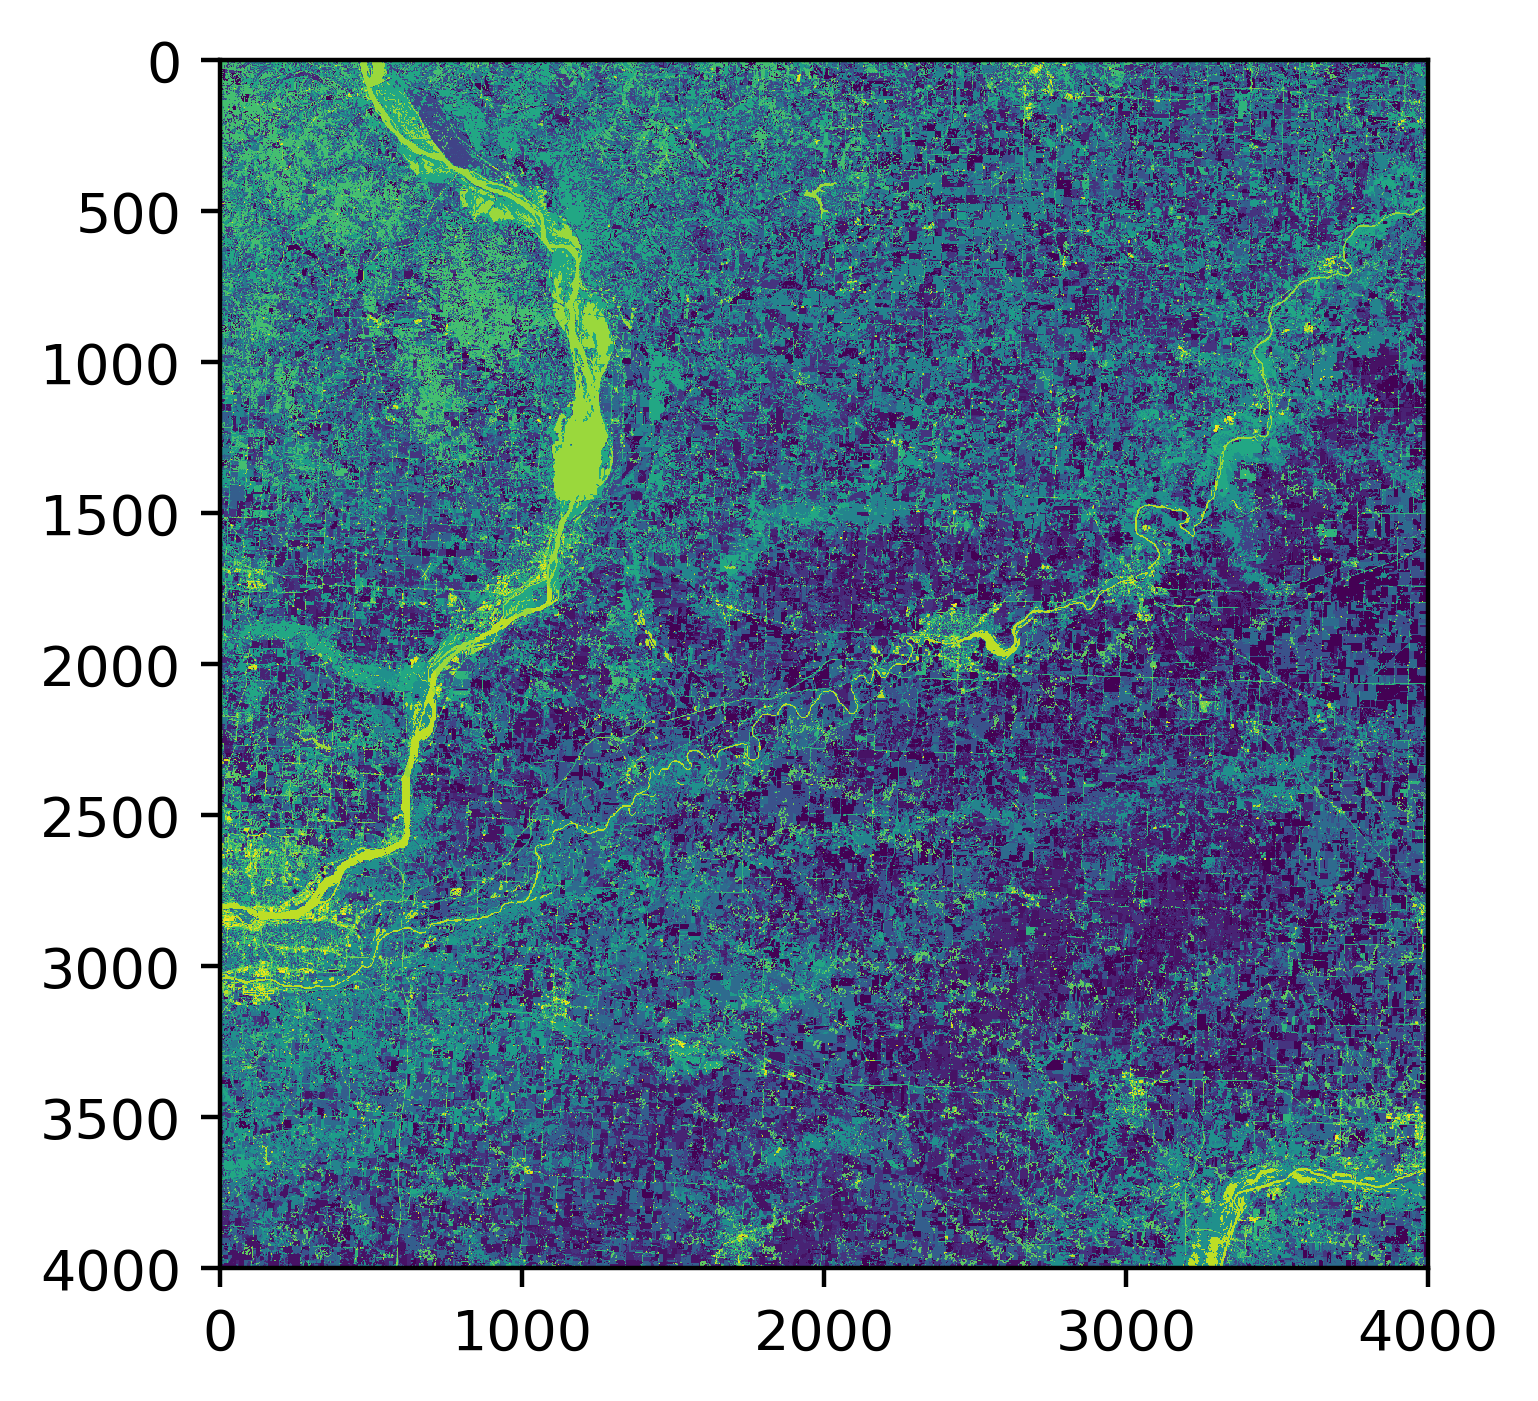

In [28]:
%%time
kmeans = KMeans(n_clusters=21)
mvp.cluster(kmeans)
plt.figure(dpi=400)
plt.imshow(mvp.rebuild())

In [29]:
img = mvp.rebuild()

In [30]:
img.shape

(4000, 4000)

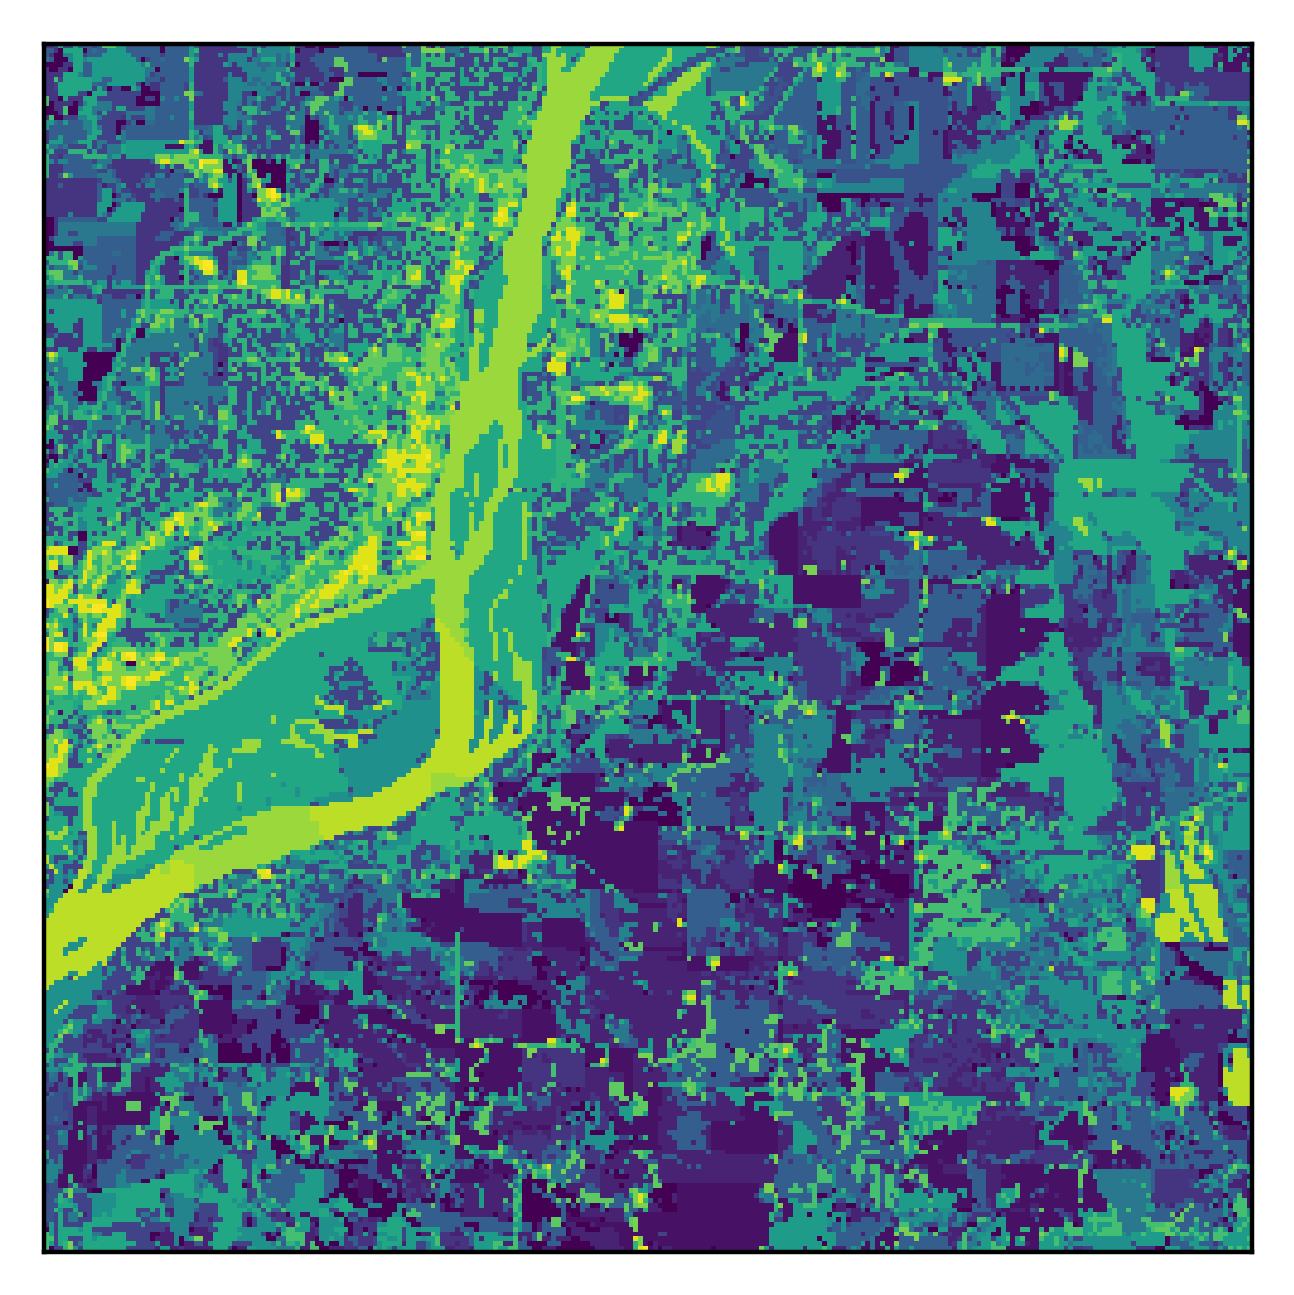

In [70]:
plt.figure(dpi=400)
plt.imshow(img[1500:2000,920:1420])
plt.xticks(())
plt.yticks(());

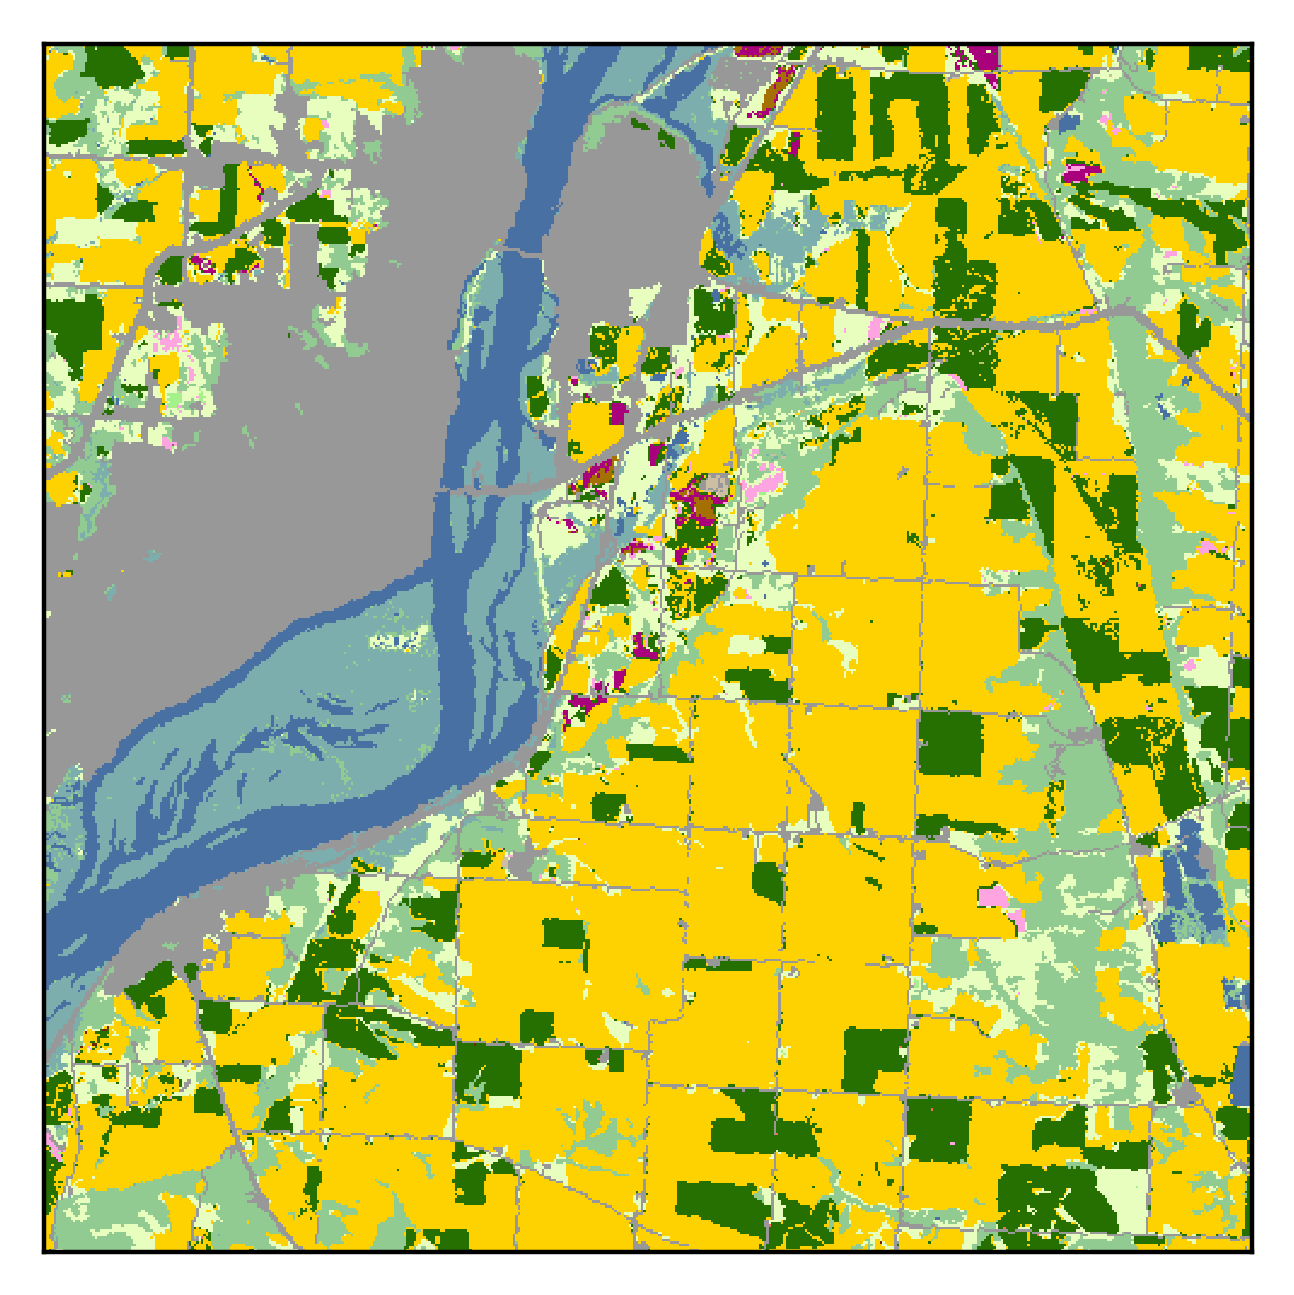

In [36]:
plot_crop_layer(crops[1500:2000,920:1420], cmap)

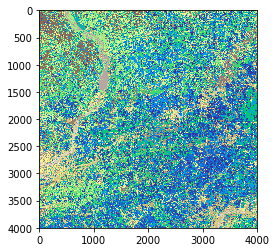

In [17]:
## plt.figure(dpi=400)
plt.imshow(mvp.rebuild(), cmap="terrain")

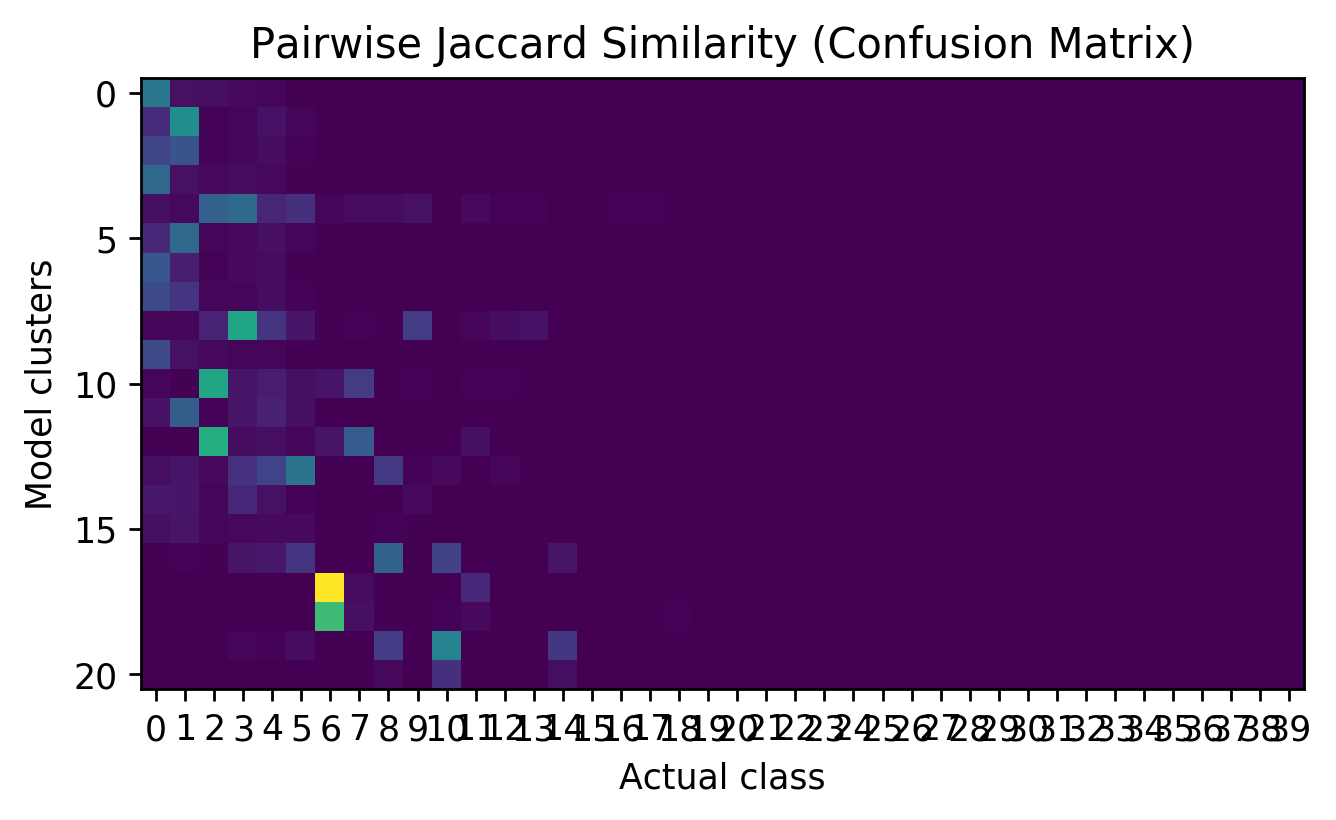

In [33]:
## %%time
clusters = mvp.rebuild().ravel()
true_labels = rank_labels(crops.ravel())
jaccard_scores = pairwise_jaccard(clusters,true_labels)

plt.figure(dpi=250)
plt.imshow(jaccard_scores)
plt.title("Pairwise Jaccard Similarity (Confusion Matrix)")
plt.xlabel("Actual class")
plt.ylabel("Model clusters")
plt.xticks(np.arange(jaccard_scores.shape[1]));

In [37]:
display_counts(crops)

val | Label                           |  num | ( red,  grn, blue, a)
----+---------------------------------+------+----------------------
  1 | Corn                            | 7009068 | (1.00, 0.83, 0.00, 1)
  5 | Soybeans                        | 3586447 | (0.15, 0.44, 0.00, 1)
141 | Deciduous Forest                | 1759124 | (0.58, 0.80, 0.58, 1)
176 | Grass/Pasture                   | 1409960 | (0.91, 1.00, 0.75, 1)
121 | Developed/Open Space            | 684167 | (0.60, 0.60, 0.60, 1)
122 | Developed/Low Intensity         | 468794 | (0.60, 0.60, 0.60, 1)
111 | Open Water                      | 314351 | (0.29, 0.44, 0.64, 1)
190 | Woody Wetlands                  | 226283 | (0.49, 0.69, 0.69, 1)
123 | Developed/Med Intensity         | 159648 | (0.60, 0.60, 0.60, 1)
 36 | Alfalfa                         | 132344 | (1.00, 0.65, 0.89, 1)
124 | Developed/High Intensity        | 58256 | (0.60, 0.60, 0.60, 1)
195 | Herbaceous Wetlands             | 56248 | (0.49, 0.69, 0.69, 1)
 24 | Wi

In [38]:
labels = most_common_labels(crops, coded_labels)

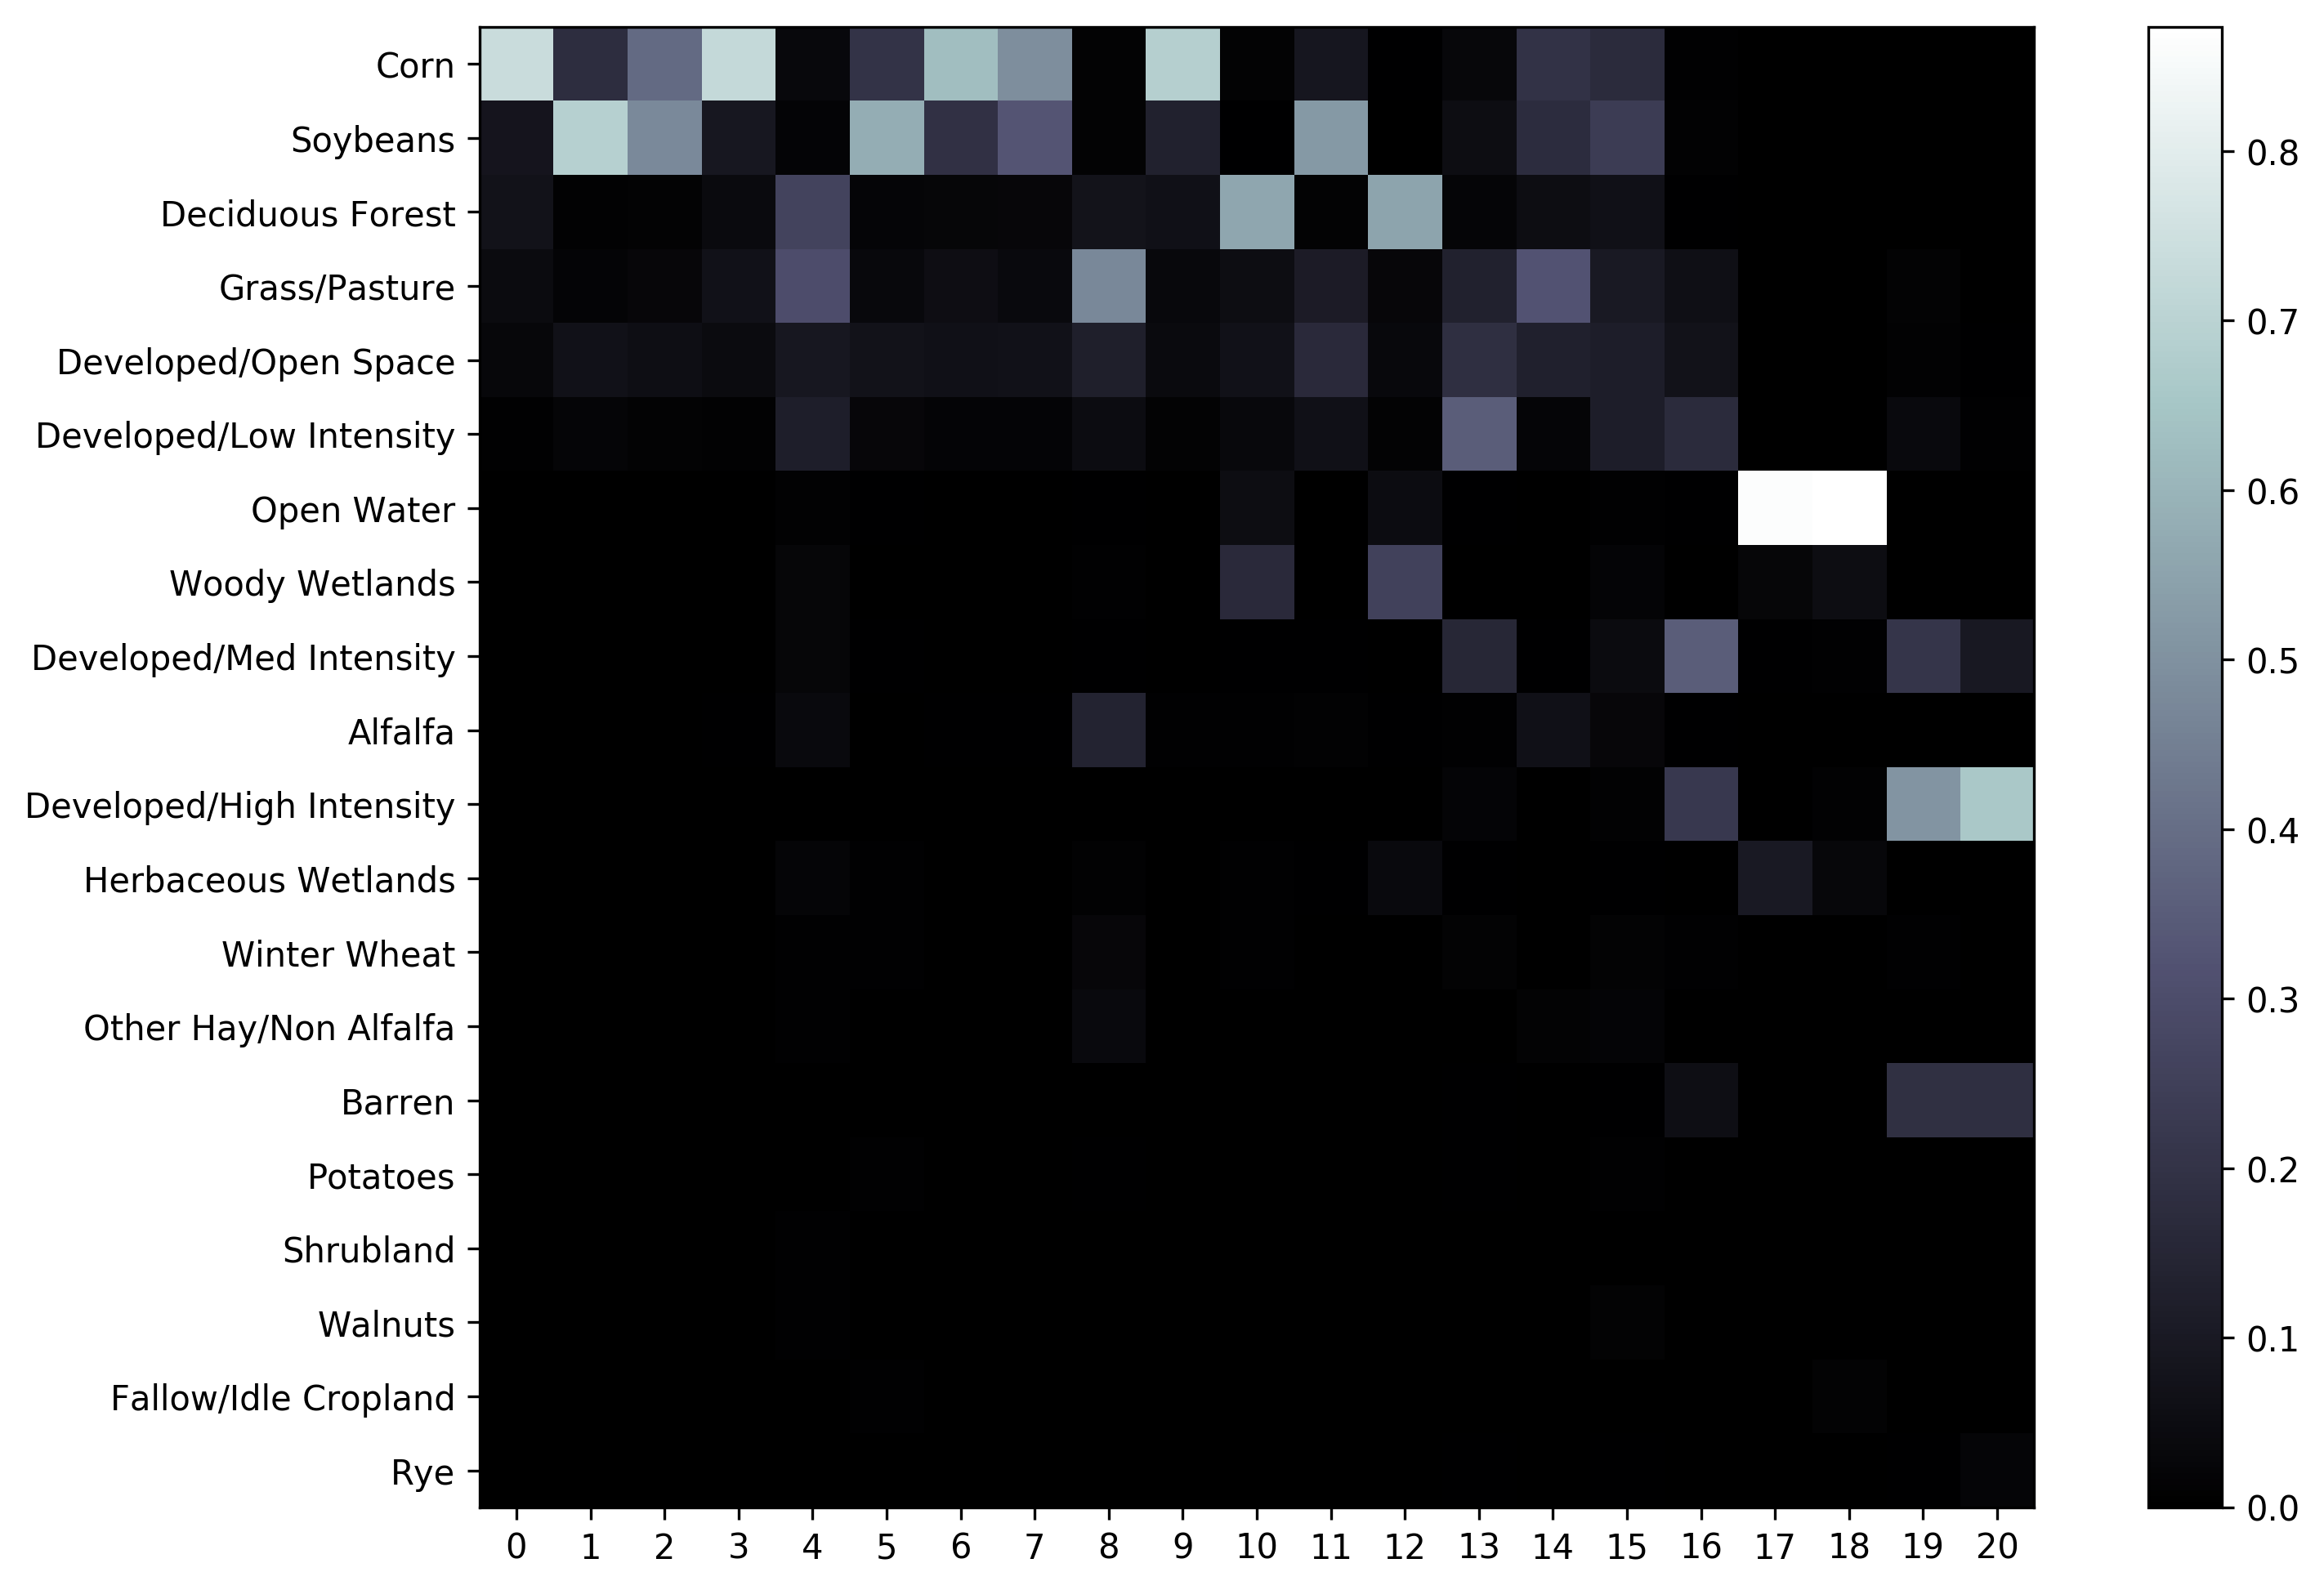

In [39]:
plot_pairwise( jaccard_scores[:,:20], labels[:], cmap="bone")

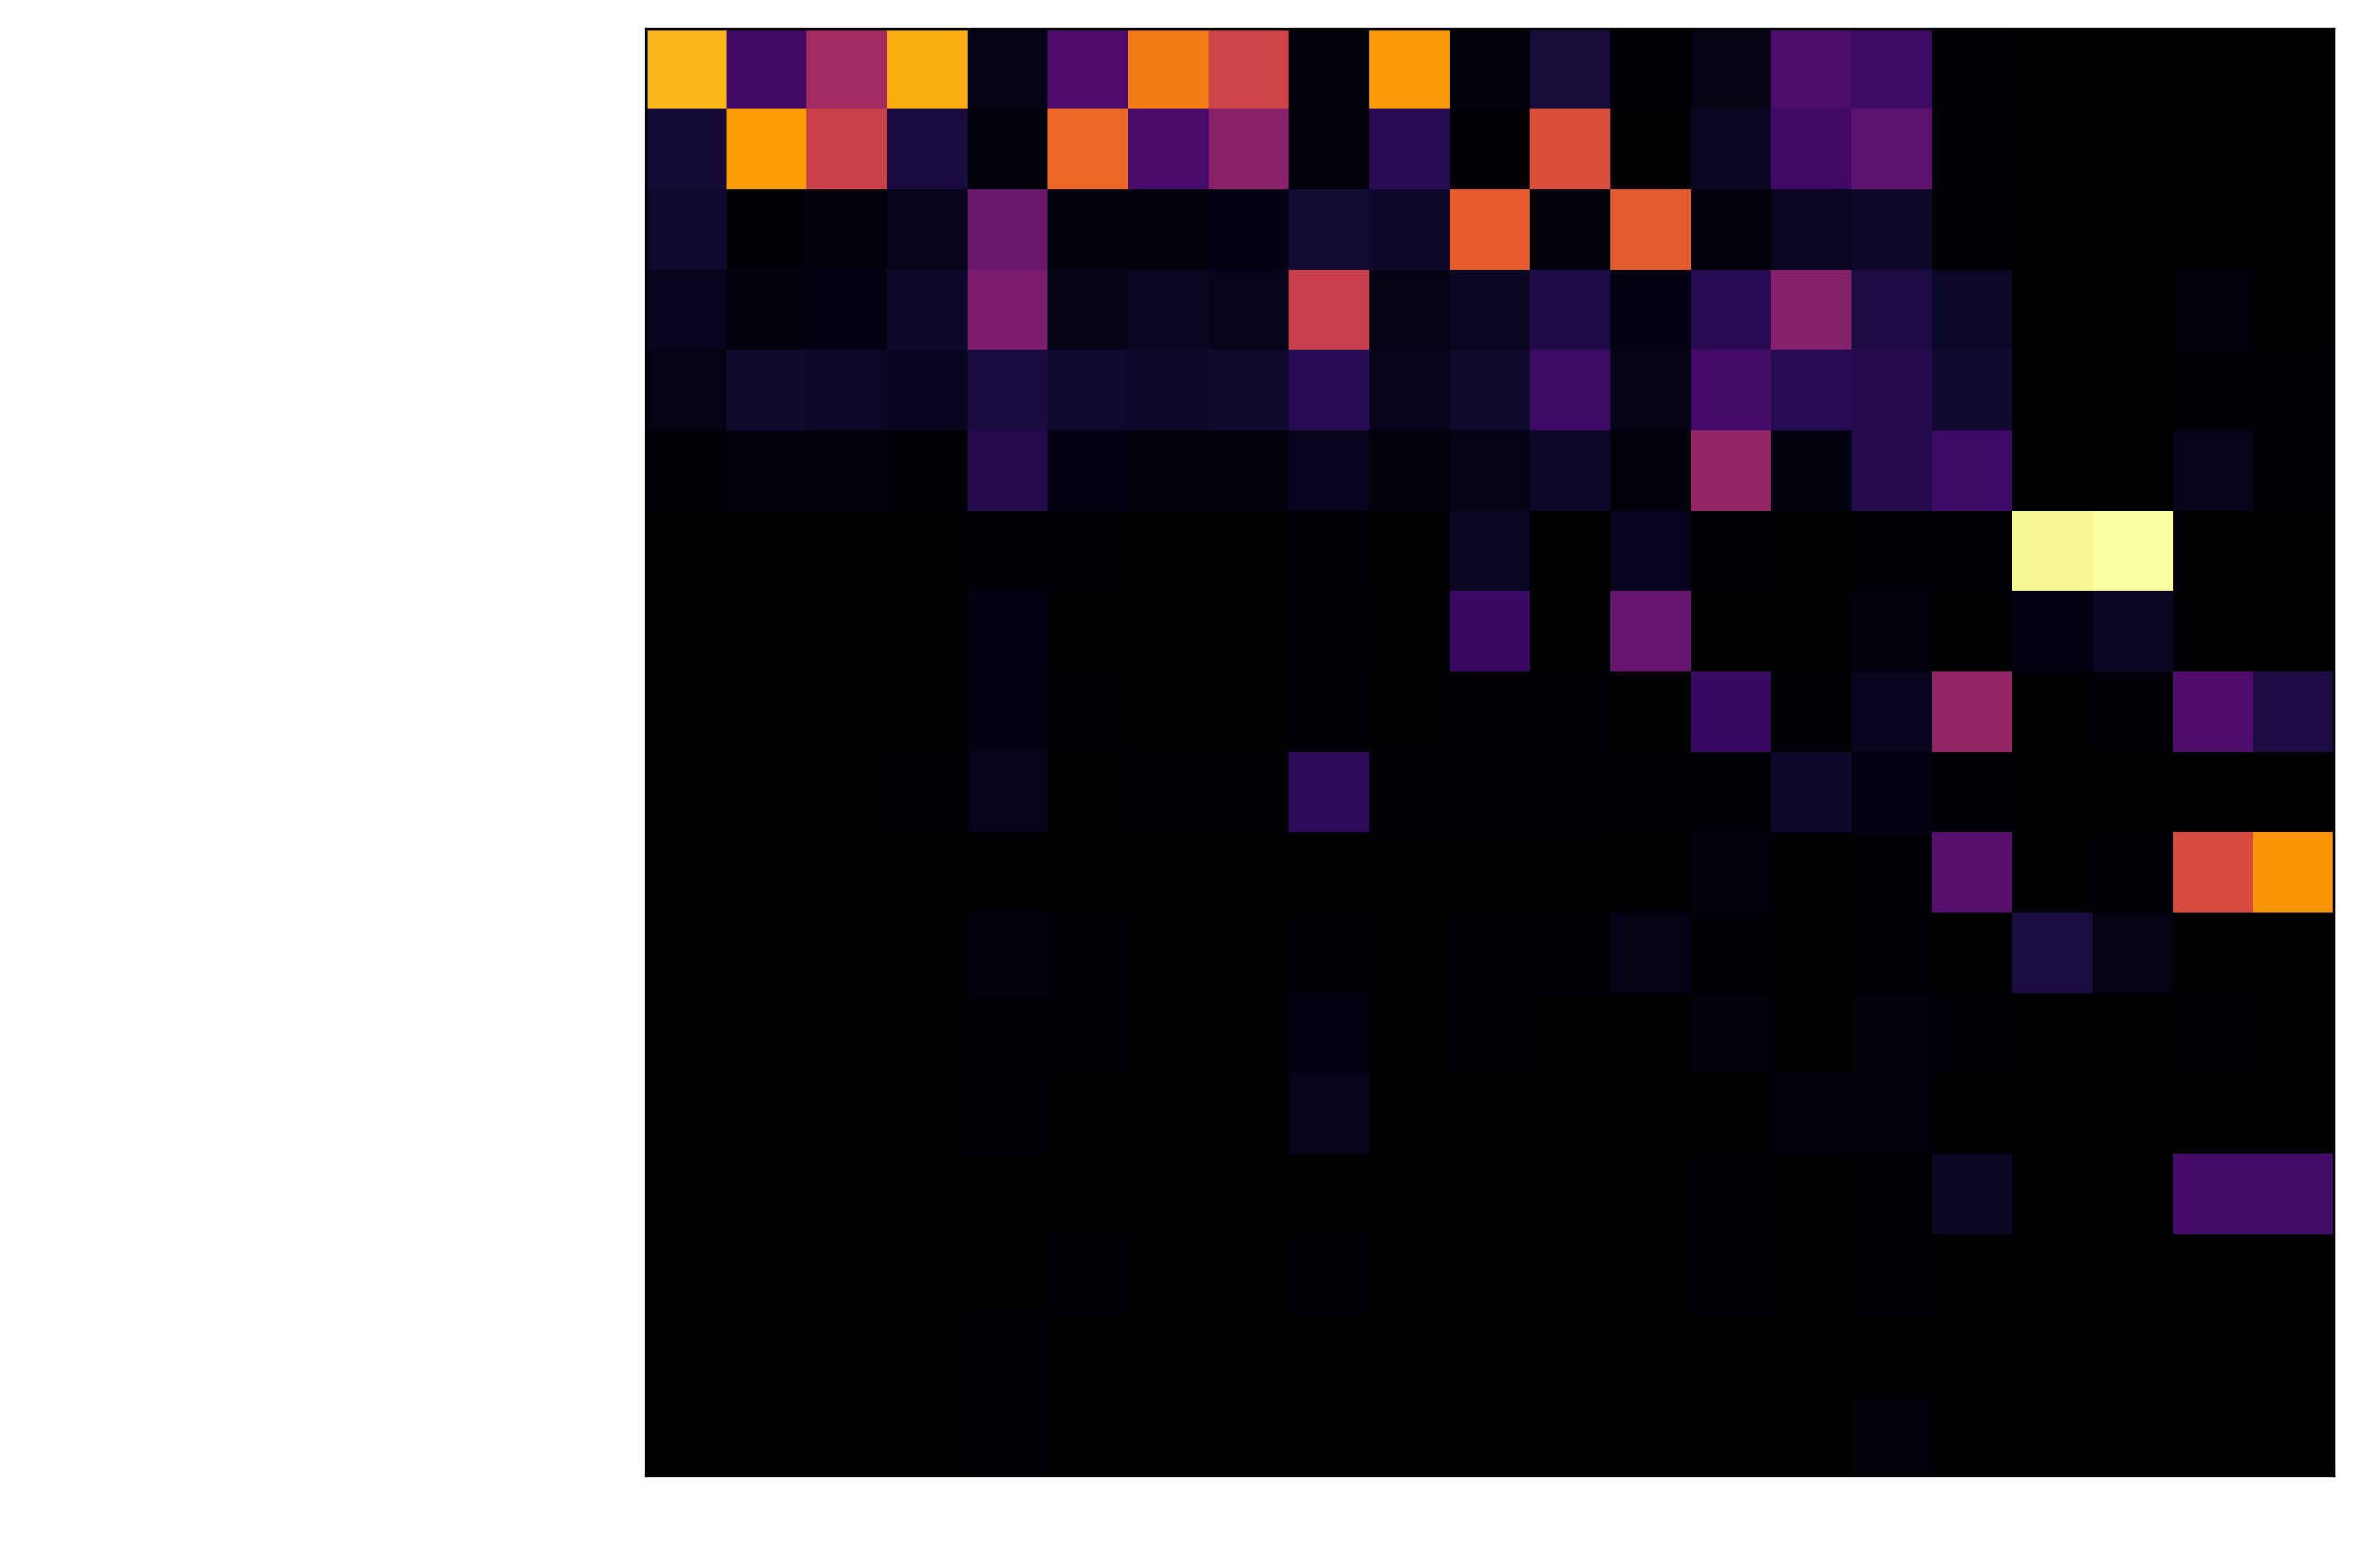

In [64]:
plot_pairwise( jaccard_scores[:,:18], labels[:18], cmap="inferno")


In [59]:
cmaps = "s_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Vega10, Vega10_r, Vega20, Vega20_r, Vega20b, Vega20b_r, Vega20c, Vega20c_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r"

list(map(print, filter(lambda a: "_r" not in a, cmaps.split(", "))));
# for c in cmaps.split(", "):
#     if "_r" not in c:
#         print(c)"""

Greys
OrRd
Oranges
PRGn
Paired
Pastel1
Pastel2
PiYG
PuBu
PuBuGn
PuOr
PuRd
Purples
RdBu
RdGy
RdPu
RdYlBu
RdYlGn
Reds
Set1
Set2
Set3
Spectral
Vega10
Vega20
Vega20b
Vega20c
Wistia
YlGn
YlGnBu
YlOrBr
YlOrRd
afmhot
autumn
binary
bone
brg
bwr
cool
coolwarm
copper
cubehelix
flag
gist_earth
gist_gray
gist_heat
gist_ncar
gist_stern
gist_yarg
gnuplot
gnuplot2
gray
hot
hsv
inferno
jet
magma
nipy_spectral
ocean
pink
plasma
prism
rainbow
seismic
spectral
spring
summer
tab10
tab20
tab20b
tab20c
terrain
viridis
winter


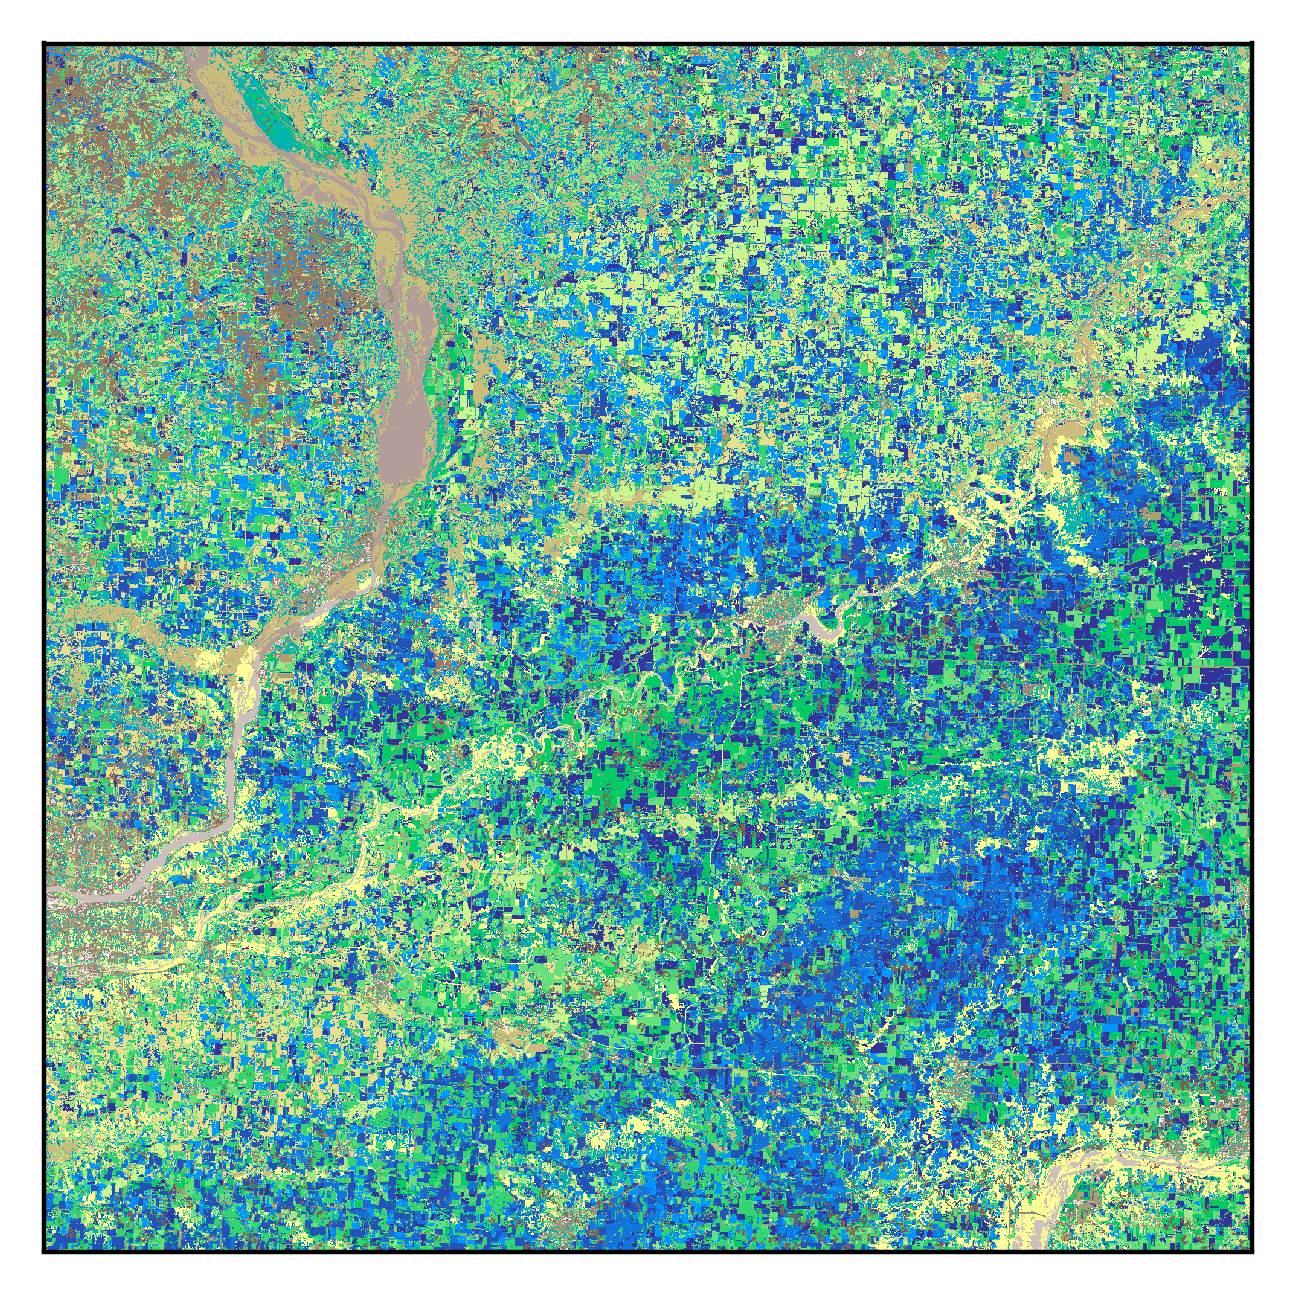

In [67]:
plt.figure(dpi=400)
plt.imshow(mvp.rebuild(), cmap="terrain")
plt.xticks(())
plt.yticks(());

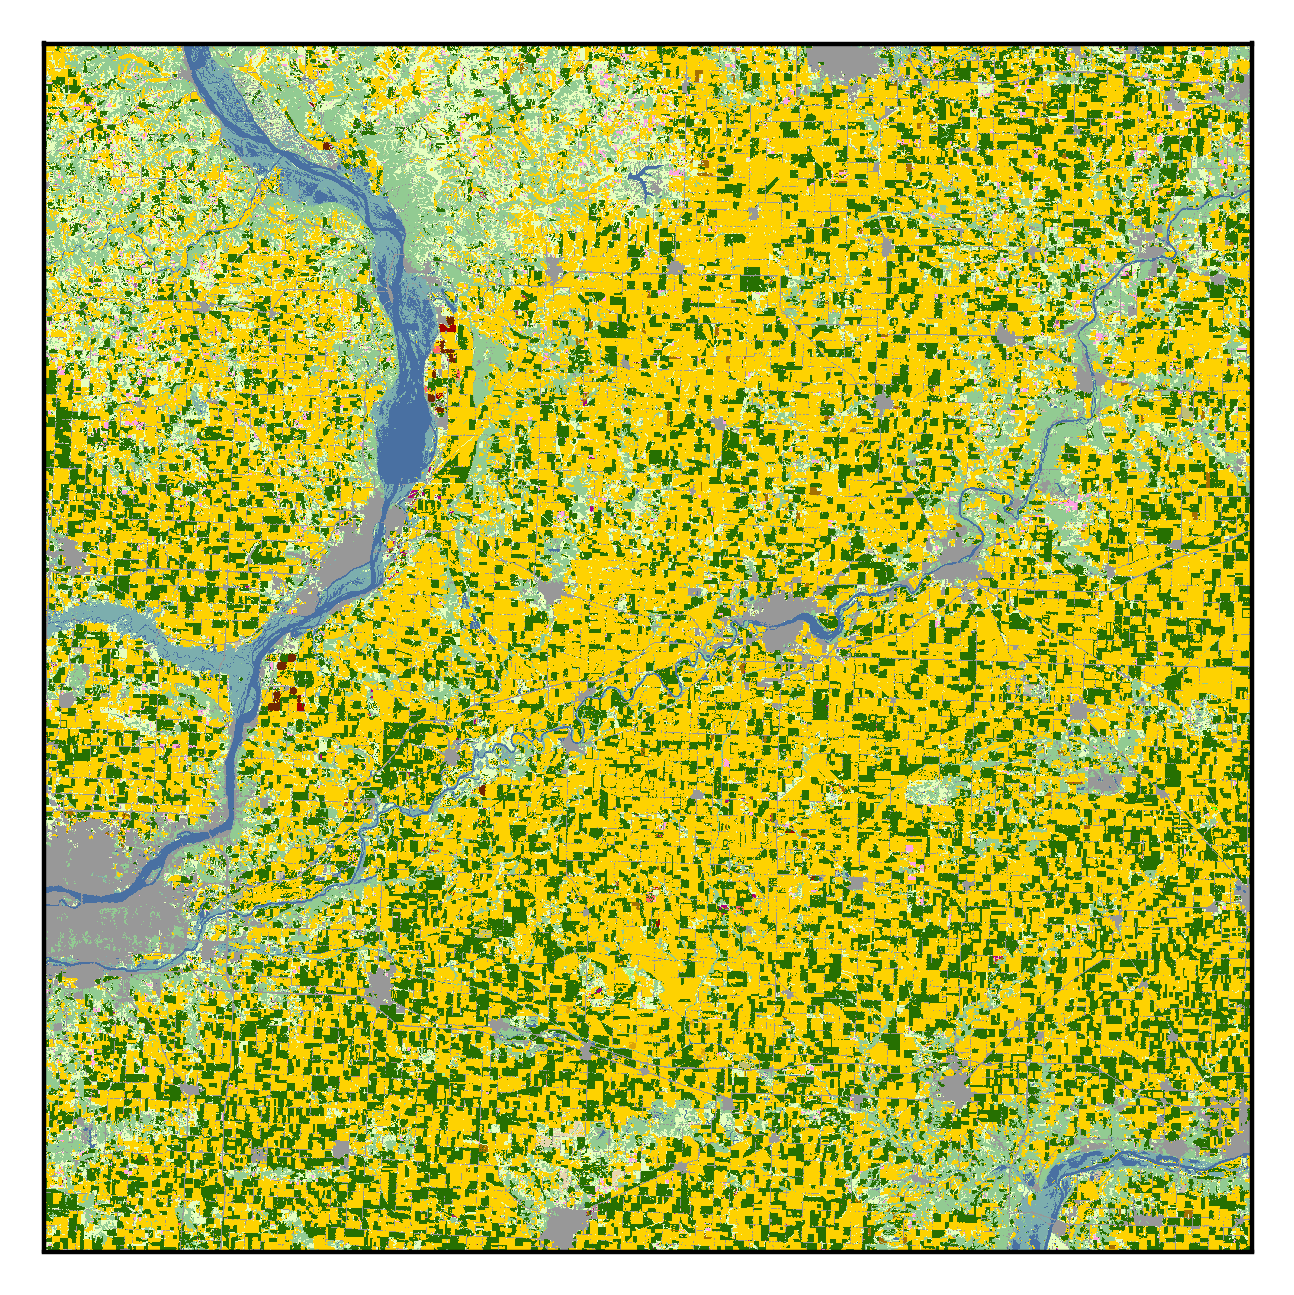

In [68]:
plot_crop_layer(crops, cmap)

In [27]:
m = mvp.scene.geotransform
m

(143085.0, 30.0, 0.0, 4747215.0, 0.0, -30.0)

In [28]:
l = labeled_data.GetGeoTransform()
l

(41175.0, 30.0, 0.0, 4761765.0, 0.0, -30.0)